In [2]:
import os
import pandas as pd
import seaborn as sns
sns.set_context('notebook')
import matplotlib.pyplot as plt
import numpy as np
from typing import List

from PIL import Image

In [3]:
# copy/paste from bajor
# https://github.com/mwalmsley/bajor/blob/main/azure/batch/scripts/predict_on_catalog.py#L165

def predictions_to_expectation_of_answer(predictions: np.ndarray, question_indices: List[int], answer_index: int) -> np.ndarray:
    """
    Calculate expected vote fraction for some answer, from Zoobot dirichlet predictions
    https://en.wikipedia.org/wiki/Dirichlet_distribution
    See properties, moments, E[Xi]
    Args:
        predictions (np.ndarray): Dirichlet concentrations of shape (n_galaxies, n_answers)
        question_indices (List[int]): Start and end column index of the question's answers (e.g. [0, 2] for smooth or featured)
        answer_index (int): Column index of the answer (e.g. 0 for smooth)
    Returns:
        np.ndarray: expected value of Dirichlet variable for that answer (i.e. the fraction of volunteers giving that answer), shape (n_galaxies)
    """

    # could do in one line but might as well be explicit/clear
    alpha_all = predictions[:, question_indices[0]:question_indices[1]+1].sum(axis=1)
    alpha_i = predictions[:, answer_index]
    return alpha_i / alpha_all


def predictions_to_variance_of_answer(predictions: np.ndarray,  question_indices: List[int], answer_index: int) -> np.ndarray:
    """
    Calculate variance (uncertainty) on vote fraction for some answer, from Zoobot dirichlet predictions
    https://en.wikipedia.org/wiki/Dirichlet_distribution
    See properties, moments, Var[Xi]
    Args:
        predictions (np.ndarray): Dirichlet concentrations of shape (n_galaxies, n_answers)
        question_indices (List[int]): Start and end column index of the question's answers (e.g. [0, 2] for smooth or featured)
        answer_index (int): Column index of the answer (e.g. 0 for smooth)
    Returns:
        np.ndarray: Variance (uncertainty) of Dirichlet variable for that answer (i.e. the variance on the fraction of volunteers giving that answer), shape (n_galaxies)
    """
    alpha_all = predictions[:, question_indices[0]:question_indices[1]+1].sum(axis=1)
    alpha_i = predictions[:, answer_index]
    return alpha_i * (alpha_all - alpha_i) / (alpha_all**2 * (alpha_all + 1))


In [4]:
from zoobot.shared.schemas import cosmic_dawn_ortho_schema
schema = cosmic_dawn_ortho_schema



In [5]:
# import h5py

# with h5py.File('/home/walml/repos/gz-decals-classifiers/results/finetune_5485077/test_predictions.hdf5') as f:
#     predictions = f['predictions'][:]
    

In [52]:
# pred_df = pd.read_csv('/home/walml/repos/gz-decals-classifiers/results/finetune_46078661/test_predictions.csv')  # 1 epoch
pred_df = pd.read_csv('/home/walml/repos/gz-decals-classifiers/results/finetune_32509981/test_predictions.csv')  # 31 epochs, 2 layers
# pred_df = pd.read_csv('/home/walml/repos/gz-decals-classifiers/results/finetune_32963887/test_predictions.csv')  # 31 epochs, 2 layers

In [53]:


label_df = pd.read_parquet('/nvme1/scratch/walml/repos/zoobot/data/gz_cosmic_dawn_early_aggregation_with_file_locs.parquet')
df = pd.merge(pred_df, label_df, on='id_str', suffixes=('_pred', '_count'))

predictions = df[[col + '_pred' for col in schema.label_cols]].values



In [54]:
predictions

array([[28.64621925, 29.35116005, 20.27278137, ...,  8.08798409,
         8.99378777, 90.46717072],
       [44.61985779, 25.94561958,  7.22652864, ..., 23.71993065,
        13.47078609, 92.38678741],
       [32.29483795,  5.90330076, 47.0424614 , ...,  6.48906183,
        33.09339142, 93.82939148],
       ...,
       [82.88233948,  3.73699808, 20.84547806, ..., 16.33110428,
        16.5657196 , 92.56607056],
       [74.99006653,  3.93226886, 25.20609283, ...,  7.01725197,
        13.15158081, 95.81681824],
       [30.07400703, 27.4772644 , 11.77676296, ..., 11.3226881 ,
        10.54280758, 92.9571228 ]])

In [55]:

# df['smooth_mean'] = predictions_to_expectation_of_answer(predictions, [0,2], 0)
# df['smooth_var'] = predictions_to_variance_of_answer(predictions, [0,2], 0)

In [56]:
from scipy.stats import betabinom

In [57]:
predictions

array([[28.64621925, 29.35116005, 20.27278137, ...,  8.08798409,
         8.99378777, 90.46717072],
       [44.61985779, 25.94561958,  7.22652864, ..., 23.71993065,
        13.47078609, 92.38678741],
       [32.29483795,  5.90330076, 47.0424614 , ...,  6.48906183,
        33.09339142, 93.82939148],
       ...,
       [82.88233948,  3.73699808, 20.84547806, ..., 16.33110428,
        16.5657196 , 92.56607056],
       [74.99006653,  3.93226886, 25.20609283, ...,  7.01725197,
        13.15158081, 95.81681824],
       [30.07400703, 27.4772644 , 11.77676296, ..., 11.3226881 ,
        10.54280758, 92.9571228 ]])

In [58]:
def show_galaxies(df, start_index=0, crop_size=50):
    fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(12, 5))
    all_axes = [ax for row in axes for ax in row]
    for n in range(10):
        galaxy = df.iloc[start_index+n]
        im = Image.open(os.path.join('/nvme1/scratch/walml/repos/zoobot', galaxy['file_loc'])).crop((50, 50, 424-crop_size, 424-crop_size))
        ax = all_axes[n]
        ax.imshow(im)
        ax.axis(False)
        n = galaxy['smooth-or-featured-cd_total-votes']
        # a = galaxy['smooth-or-featured-cd_smooth']
        # b = galaxy['smooth-or-featured-cd_featured-or-disk'] + galaxy['smooth-or-featured-cd_problem']
        a = galaxy['smooth-or-featured-cd_smooth_pred']
        b = galaxy['smooth-or-featured-cd_featured-or-disk_pred'] + galaxy['smooth-or-featured-cd_problem']
        samples = betabinom(int(n), a, b).rvs(size=100)
        ax.text(20, 70, 'Pred: {}-{}-{} ({:.2f})'.format(int(np.quantile(samples, 0.05)), int(np.median(samples)), int(np.quantile(samples, 0.95)), a/(a+b)), color='r')
        ax.text(20, 40, 'Actual: {} of {} ({:.2f})'.format(int(galaxy['smooth-or-featured-cd_smooth']), int(n), galaxy['smooth-or-featured-cd_smooth_fraction']), color='r')
        
    fig.tight_layout()

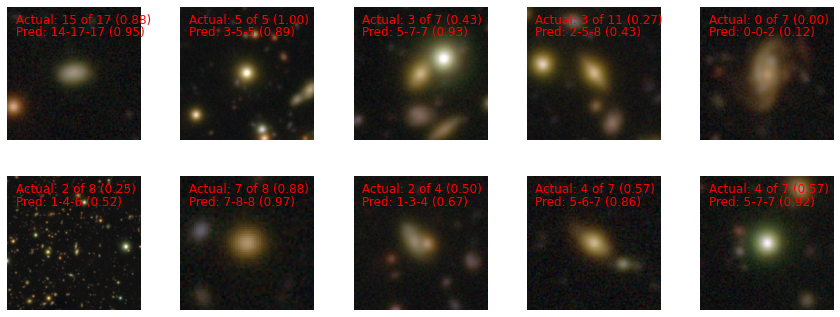

In [62]:
show_galaxies(df.sample(10))